In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

from PIL import Image
import os

def extract_32x32_patches_from_images(image_paths):
    """
    Args:
        image_paths (List[str]): List of image file paths
    Returns:
        List[Tensor]: List of 32x32 patches (each as a 3×32×32 torch.Tensor)
    """
    transform = transforms.ToTensor()
    all_patches = []

    for path in image_paths:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img)  # [C, H, W]
        C, H, W = img_tensor.shape

        # Calculate bounds (floor to nearest multiple of 32)
        H32 = H - (H % 32)
        W32 = W - (W % 32)

        for i in range(0, H32, 32):
            for j in range(0, W32, 32):
                patch = img_tensor[:, i:i+32, j:j+32]
                all_patches.append(patch)

    return all_patches

In [ ]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

def save_patches(patch_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, patch in enumerate(patch_list):
        save_path = os.path.join(save_dir, f"patch_{i:05d}.png")
        save_image(patch, save_path)

# -----------------------------
# Step 3: Run everything
# -----------------------------

# Set your input and output paths
image_dir = '/content/drive/MyDrive/latent_exp_2025/training_images_'
#save_dir = '/content/drive/MyDrive/latent_exp_2025/patches_32x32'

# Collect image paths
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Extract patches
patches = extract_32x32_patches_from_images(image_files)
print(f"✅ Extracted {len(patches)} patches from {len(image_files)} images.")

✅ Extracted 362664 patches from 194 images.


In [ ]:
from torch.utils.data import Dataset

class PatchDataset(Dataset):
    def __init__(self, patch_list):
        self.patches = patch_list

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], 0  # dummy label if needed

# Use it like this:
patch_dataset = PatchDataset(patches)
train_loader = torch.utils.data.DataLoader(patch_dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.latent_channels = latent_channels

        # ⬇️ Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32 → 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 16 → 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 8 → 4
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),  # keep 4×4, just deeper
            nn.ReLU()
        )

        # ⬇️ Latent heads
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)

        # ⬆️ Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1),  # 4 → 4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 4 → 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 8 → 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # 16 → 32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def quantize_training(self, z):
        noise = torch.empty_like(z).uniform_(-0.5, 0.5)
        return z + noise

    def quantize_test(self, z):
        return torch.round(z)

    def forward(self, x, quantize):
        h = self.encoder(x)              # → [B, 128, 4, 4]
        mu = self.conv_mu(h)             # → [B, 32, 4, 4]
        logvar = self.conv_logvar(h)
        z = self.reparameterize(mu, logvar)

        if quantize:
            z_hat = self.quantize_training(z) if self.training else self.quantize_test(z)
        else:
            z_hat = z

        x_recon = self.decoder(z_hat)
        return x_recon, mu, logvar, z_hat

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
import os

save_dir = '/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data'
os.makedirs(save_dir, exist_ok=True)

vae = PatchVAE(latent_channels = 64, latent_hw=2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
def loss_fn(x_recon, x, mu, logvar, beta=0.1):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl


epochs = 60
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar, z_hat = vae(x, quantize=True)
        loss = loss_fn(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    save_path = os.path.join(save_dir, f"vae_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
    }, save_path)

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader.dataset):.2f} | Saved to: {save_path}")

Epoch 1 | Loss: 34.54 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_1.pt
Epoch 2 | Loss: 23.21 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_2.pt
Epoch 3 | Loss: 22.26 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_3.pt
Epoch 4 | Loss: 21.72 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_4.pt
Epoch 5 | Loss: 21.35 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_5.pt
Epoch 6 | Loss: 21.07 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_6.pt
Epoch 7 | Loss: 20.88 | Saved to: /content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantize

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = PatchVAE(latent_channels = 64, latent_hw=2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
def loss_fn(x_recon, x, mu, logvar, beta=0.1):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl


checkpoint = torch.load("/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt", map_location=device)
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()

PatchVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (conv_mu): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_logvar): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

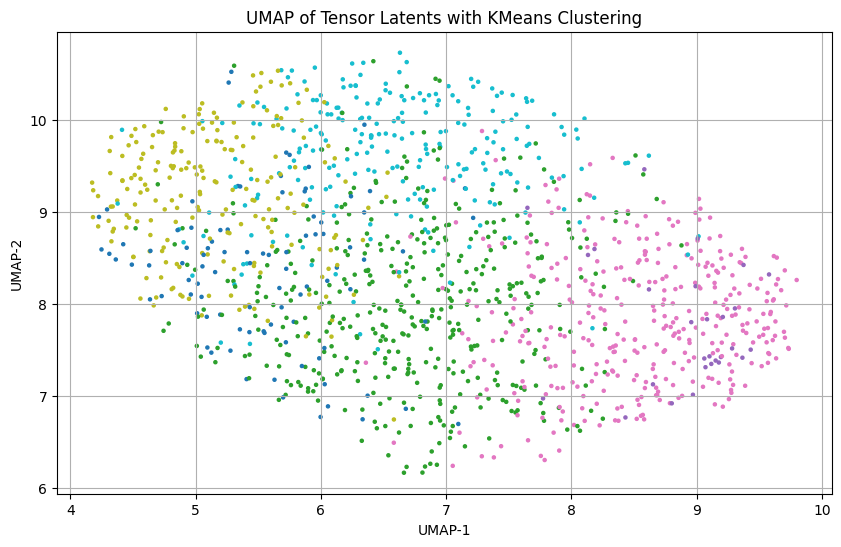

In [ ]:
import numpy as np
all_latents = []

with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _, _, _, z = vae(x, quantize=True)
        all_latents.append(z.cpu())
        if len(all_latents) > 20:
            break

# Flatten latent tensors: [N, C, H, W] → [N, C×H×W]
all_latents = torch.cat(all_latents, dim=0)
all_latents = all_latents.view(all_latents.size(0), -1).numpy()

from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
z_umap = reducer.fit_transform(all_latents)

kmeans = KMeans(n_clusters=6, random_state=0).fit(all_latents)
labels = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=labels, cmap='tab10', s=5)
plt.title("UMAP of Tensor Latents with KMeans Clustering")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


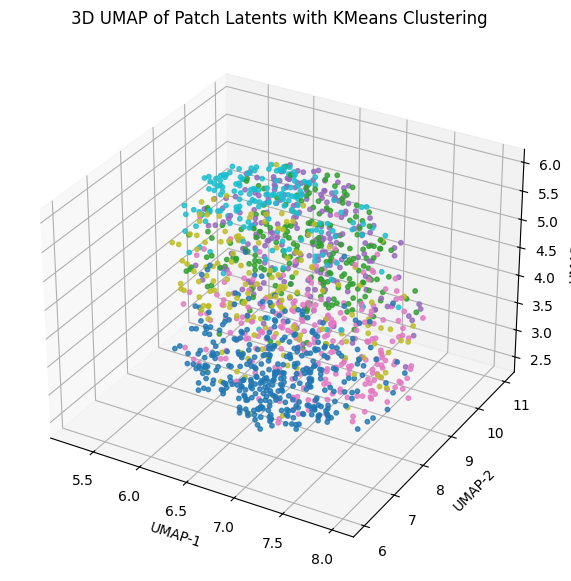

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plot

# Step 1: 3D UMAP
reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean')
z_umap_3d = reducer_3d.fit_transform(all_latents)

# Step 2: 3D Plot with clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(z_umap_3d[:, 0], z_umap_3d[:, 1], z_umap_3d[:, 2],
                     c=labels, cmap='tab10', s=10, alpha=0.8)

ax.set_title("3D UMAP of Patch Latents with KMeans Clustering")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.show()

In [ ]:
from PIL import Image
from torchvision import transforms

# Load image (e.g., 'kodim01.png')
image_path = '/content/drive/MyDrive/latent_exp_2025/example_images/RGB_R02_0600x0600_007.png'  # replace with your own path
image = Image.open(image_path).convert('RGB')

# Resize to multiple of 32 (optional, Kodak is 768×512)
W, H = image.size
W = W - (W % 32)
H = H - (H % 32)
image = image.crop((0, 0, W, H))

# Convert to tensor
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image).unsqueeze(0).to(device)  # shape: [1, 3, H, W]

In [ ]:
def extract_patches_scanline(img_tensor, patch_size=32):
    B, C, H, W = img_tensor.shape
    patches = []
    positions = []

    for row in range(0, H, patch_size):
        for col in range(0, W, patch_size):
            patch = img_tensor[:, :, row:row+patch_size, col:col+patch_size]
            patches.append(patch)
            positions.append((row // patch_size, col // patch_size))  # store (i,j) position
    return patches, positions

patches, positions = extract_patches_scanline(image_tensor)

In [ ]:
vae.eval()
scan_latents = []

with torch.no_grad():
    for patch in patches:
        _, _, _, z = vae(patch, quantize=True)  # <- quantize False for clean latent
        z_flat = z.view(z.size(0), -1)  # flatten from [1, 32, 2, 2] → [1, 128]
        scan_latents.append(z_flat.cpu().numpy()[0])  # extract [128]-dim vector

scan_latents = np.array(scan_latents)  # shape: [num_patches, 128]

In [ ]:
scan_latents

array([[ 1., -0., -0., ..., -0.,  0., -1.],
       [-1., -1., -1., ...,  2.,  1.,  1.],
       [ 0.,  0.,  0., ..., -1., -1., -0.],
       ...,
       [ 1.,  1.,  0., ..., -0.,  2., -1.],
       [-1.,  1., -0., ...,  1.,  1., -0.],
       [ 1., -1.,  1., ..., -1., -0., -0.]], dtype=float32)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


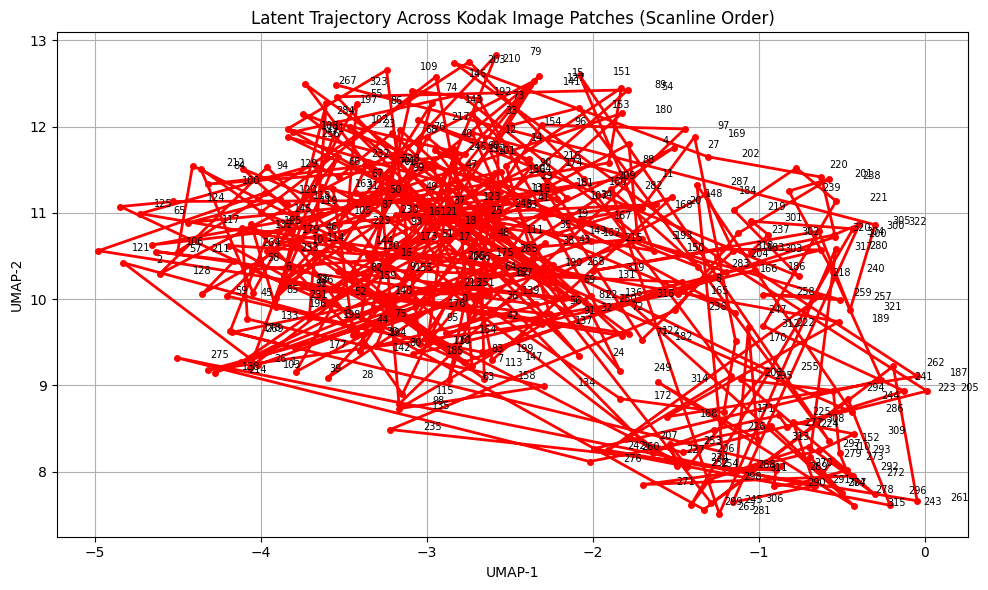

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce to 2D
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean')
umap_latents = reducer.fit_transform(scan_latents)

# Plot trajectory
plt.figure(figsize=(10, 6))
plt.plot(umap_latents[:, 0], umap_latents[:, 1], 'r-o', linewidth=2, markersize=4)

for i, (x, y) in enumerate(umap_latents):
    plt.text(x + 0.2, y, str(i), fontsize=7)

plt.title("Latent Trajectory Across Kodak Image Patches (Scanline Order)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


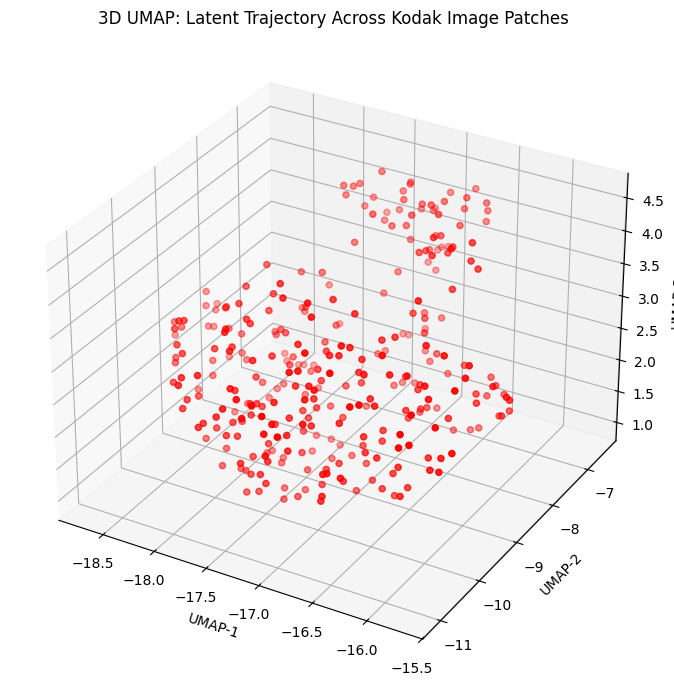

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Reduce to 3D
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', n_components=3)
umap_latents_3d = reducer.fit_transform(scan_latents)

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_latents_3d[:, 0], umap_latents_3d[:, 1], umap_latents_3d[:, 2], c='red', s=20)

# Annotate points
#for i, (x, y, z) in enumerate(umap_latents_3d):
#    ax.text(x + 0.2, y, z, str(i), fontsize=7)

ax.set_title("3D UMAP: Latent Trajectory Across Kodak Image Patches")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


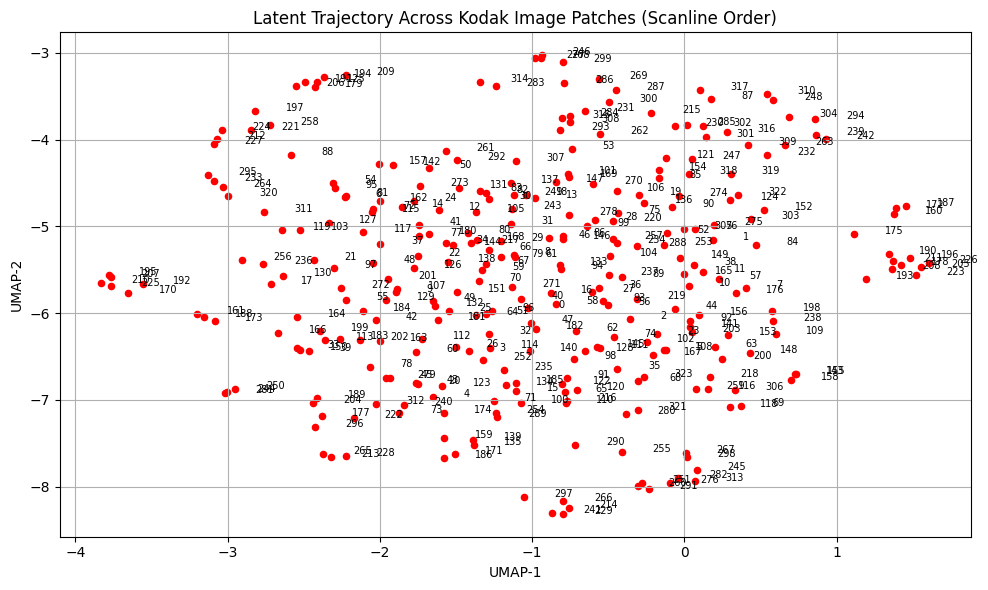

In [ ]:

# Reduce to 2D
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean')
umap_latents = reducer.fit_transform(scan_latents)

# Plot only the points
plt.figure(figsize=(10, 6))
plt.scatter(umap_latents[:, 0], umap_latents[:, 1], c='red', s=20)

# Annotate points
for i, (x, y) in enumerate(umap_latents):
    plt.text(x + 0.2, y, str(i), fontsize=7)

plt.title("Latent Trajectory Across Kodak Image Patches (Scanline Order)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import KMeans

K = 6  # number of clusters (tweak as needed)
kmeans = KMeans(n_clusters=K, random_state=42)
cluster_ids = kmeans.fit_predict(scan_latents)
cluster_centers = kmeans.cluster_centers_
# UMAP embedding of cluster centers (must reuse the same reducer)
umap_centers = reducer.transform(cluster_centers)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


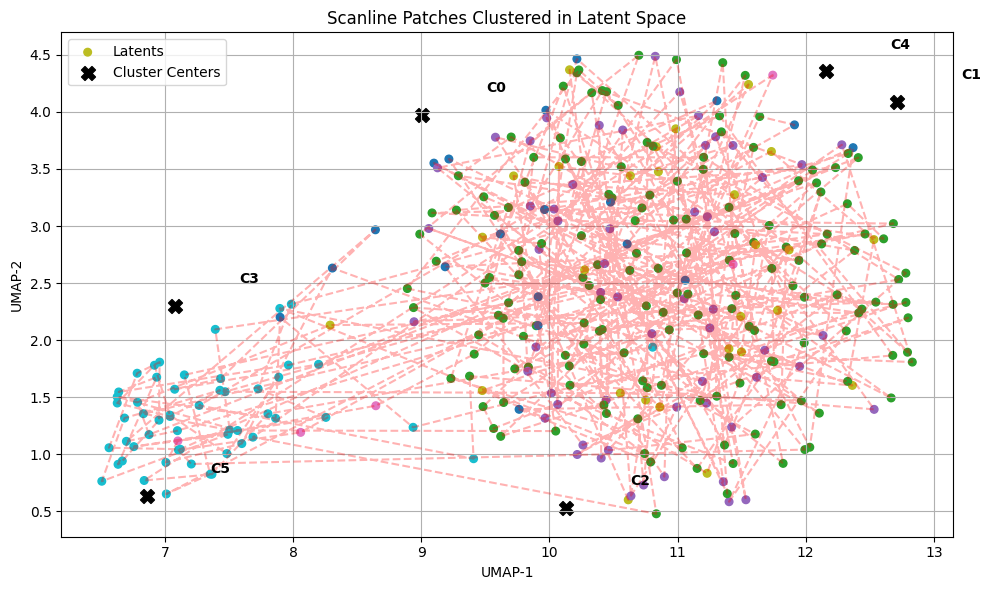

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(umap_latents[:, 0], umap_latents[:, 1],
                      c=cluster_ids, cmap='tab10', s=30, label='Latents')

plt.scatter(umap_centers[:, 0], umap_centers[:, 1],
            c='black', marker='X', s=100, label='Cluster Centers')

# Label cluster centers
for i, (x, y) in enumerate(umap_centers):
    plt.text(x + 0.5, y + 0.2, f"C{i}", fontsize=10, fontweight='bold', color='black')

plt.plot(umap_latents[:, 0], umap_latents[:, 1], 'r--', alpha=0.3)

plt.title("Scanline Patches Clustered in Latent Space")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
import umap.umap_ as umap
import networkx as nx
import community as community_louvain
from sklearn.preprocessing import StandardScaler

# === Load VAE model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = PatchVAE(latent_channels=64, latent_hw=2).to(device)
checkpoint = torch.load("/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt", map_location=device)
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()

# === Load and prepare image ===
image_path = '/content/drive/MyDrive/latent_exp_2025/example_images/RGB_R02_0600x0600_007.png'
image = Image.open(image_path).convert('RGB')
W, H = image.size
image = image.crop((0, 0, W - (W % 32), H - (H % 32)))
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # shape: [1, 3, H, W]

# === Extract 32x32 patches ===
def extract_patches_scanline(img_tensor, patch_size=32):
    B, C, H, W = img_tensor.shape
    patches, positions = [], []
    for row in range(0, H, patch_size):
        for col in range(0, W, patch_size):
            patch = img_tensor[:, :, row:row+patch_size, col:col+patch_size]
            patches.append(patch)
            positions.append((row // patch_size, col // patch_size))
    return patches, positions

patches, _ = extract_patches_scanline(image_tensor)

# === Extract latent vectors
scan_latents = []
with torch.no_grad():
    for patch in patches:
        _, _, _, z = vae(patch, quantize=True)  # quantize=False for clean latents
        z_flat = z.view(-1)  # (64*2*2 = 256,)
        scan_latents.append(z_flat.cpu().numpy())

scan_latents = np.stack(scan_latents)  # shape: (N_patches, 256)

# === UMAP Graph + Louvain Clustering ===
# 1. Standardize
latents_std = StandardScaler().fit_transform(scan_latents)

# 2. UMAP graph construction
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean')
reducer.fit(latents_std)
umap_graph = reducer.graph_

# 3. Convert to networkx graph
G = nx.from_scipy_sparse_array(umap_graph)

# 4. Louvain clustering
partition = community_louvain.best_partition(G)

# 5. Count clusters
num_clusters = len(set(partition.values()))
print("✅ Number of clusters found:", num_clusters)


✅ Number of clusters found: 11


Cluster
0     58
1     26
2     16
3     34
4     15
5     44
6     31
7     35
8     31
9     27
10     7
Name: count, dtype: int64


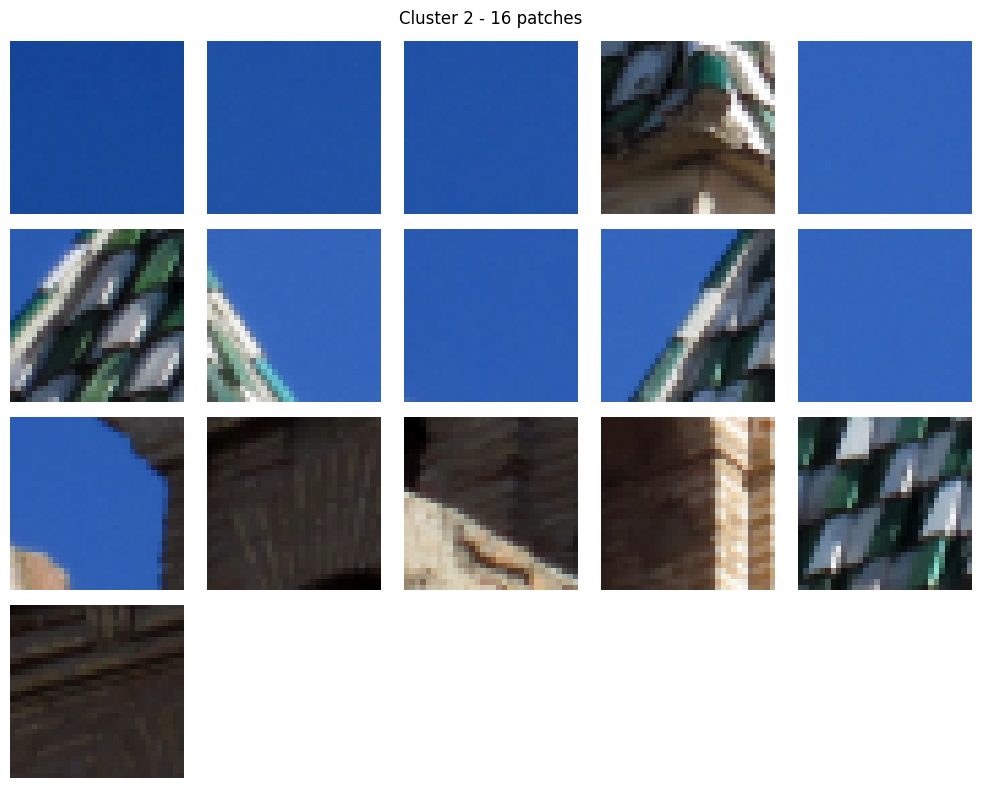

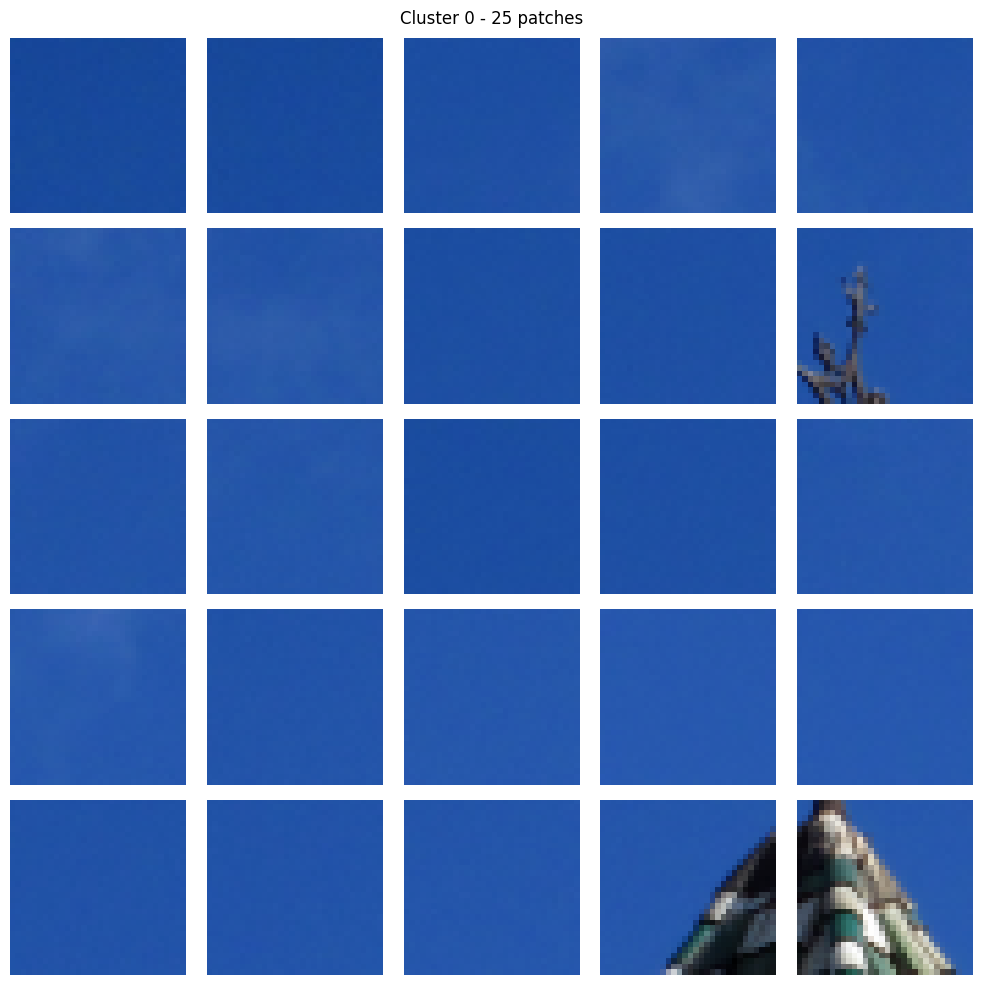

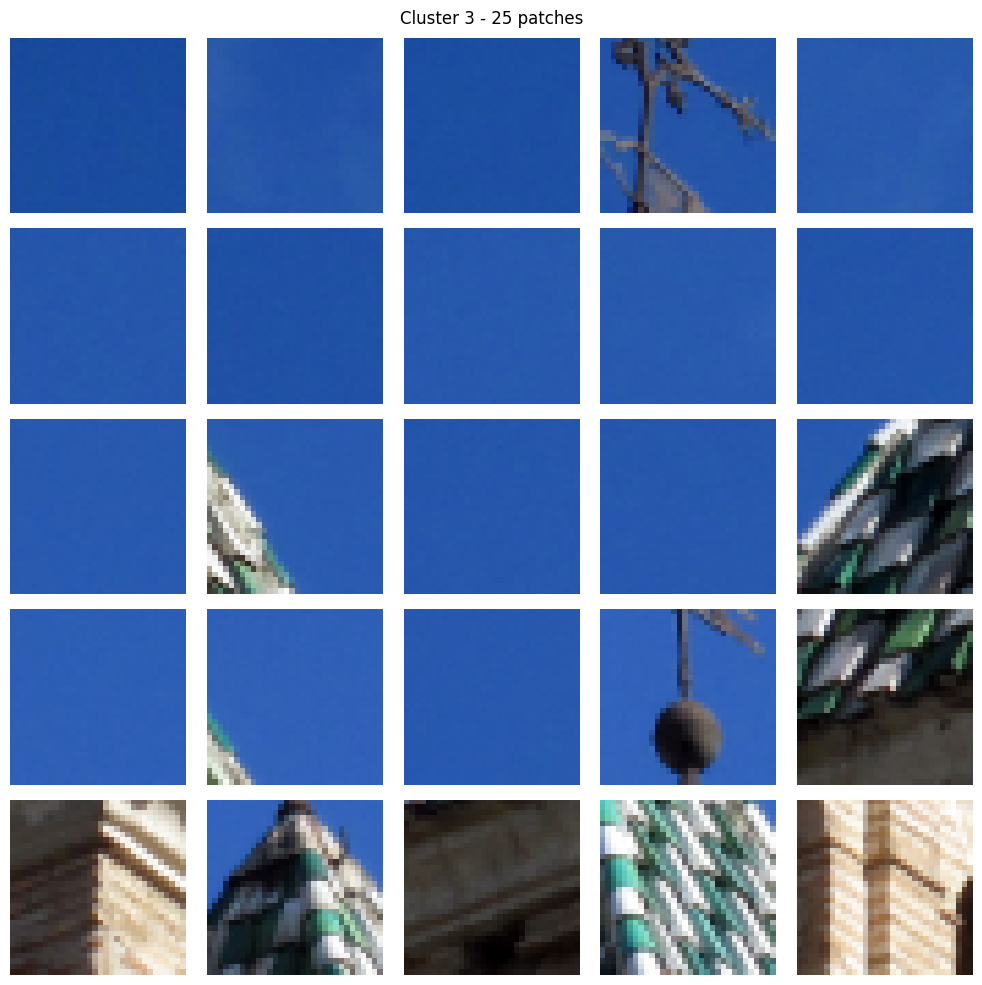

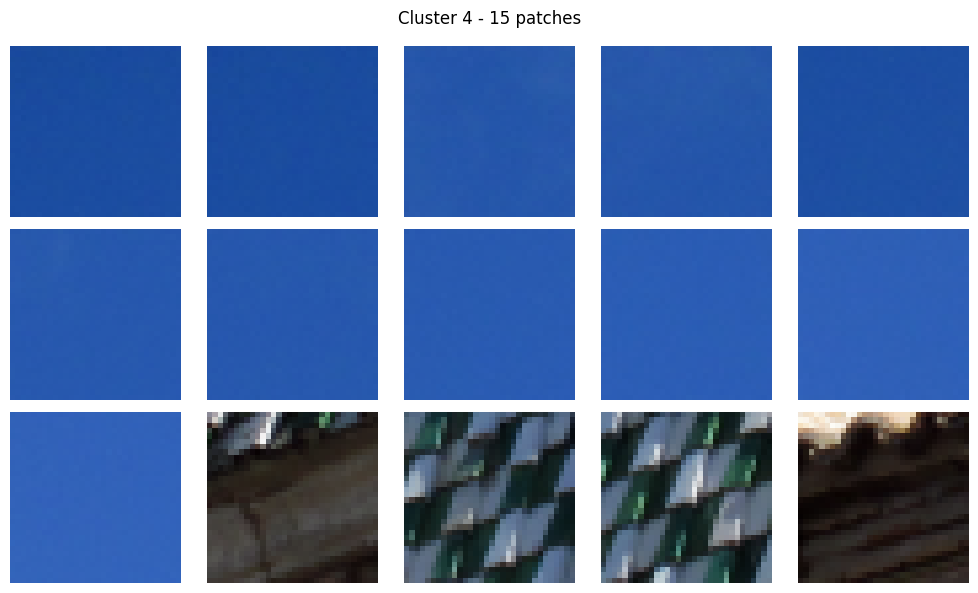

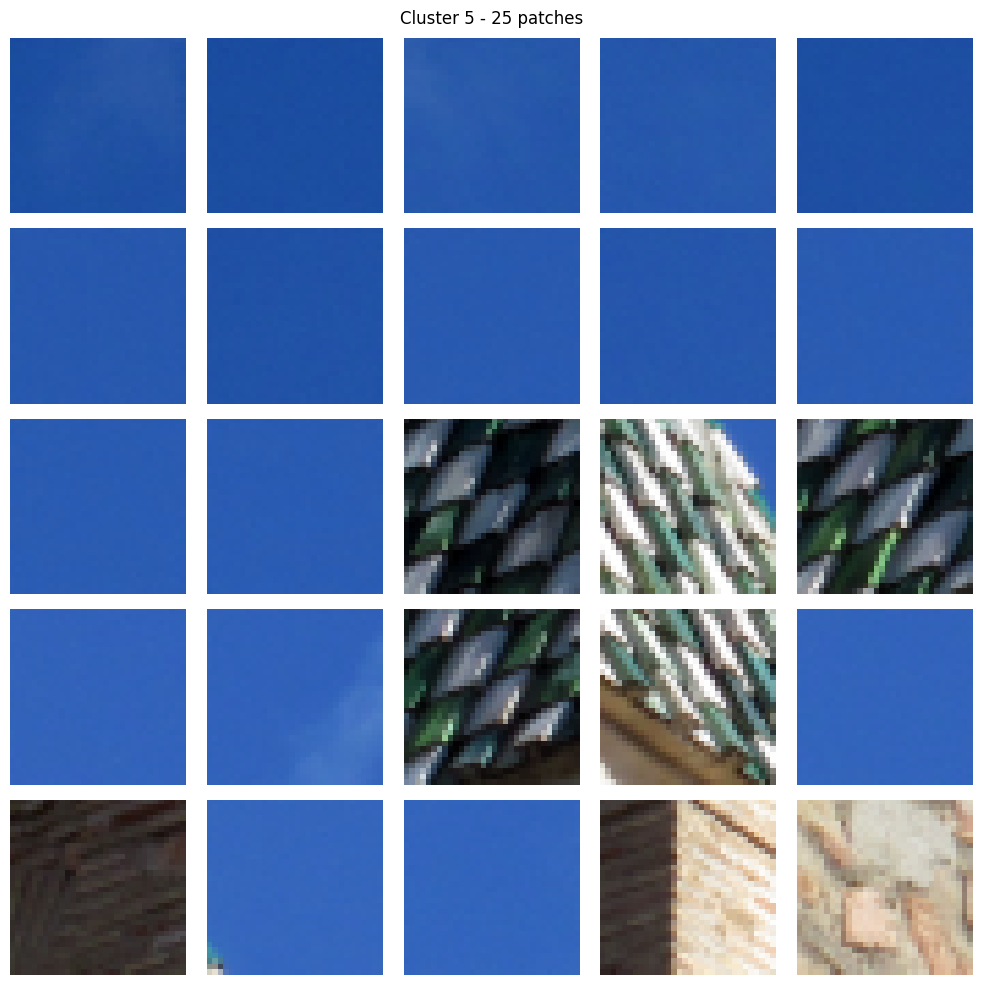

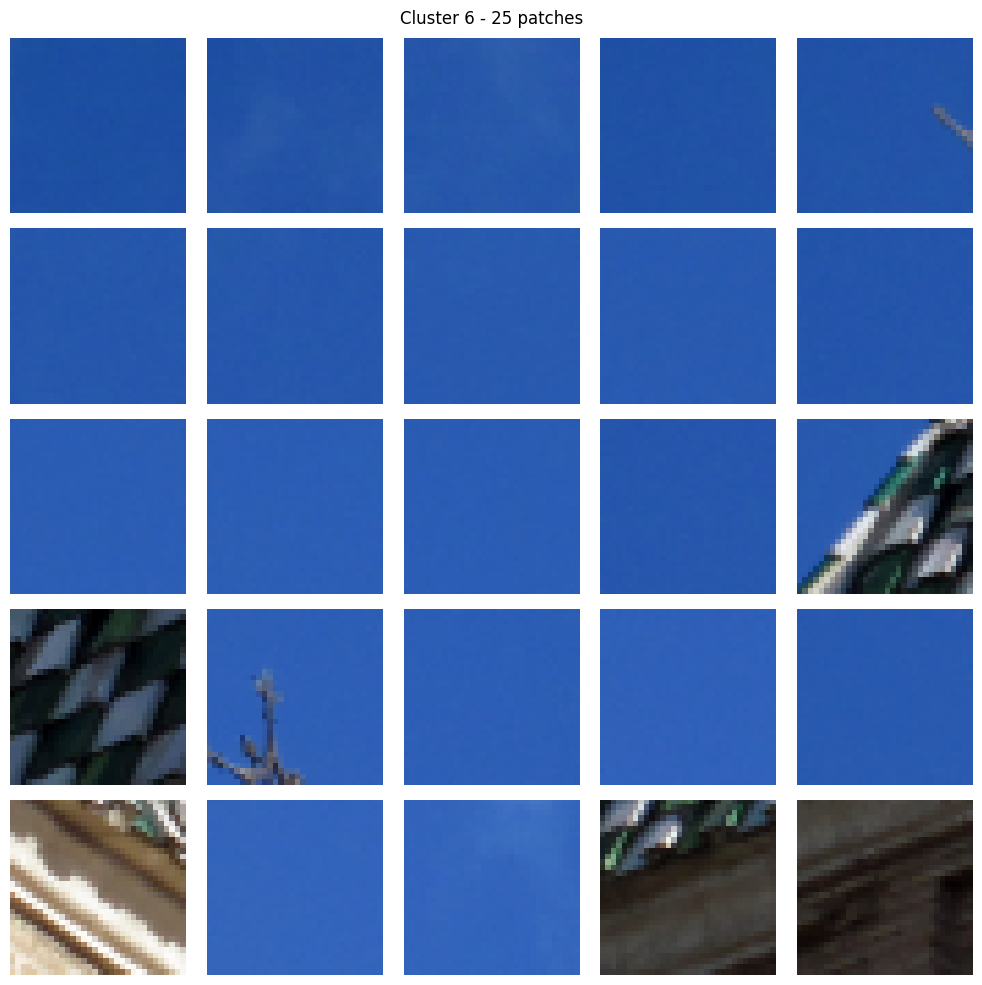

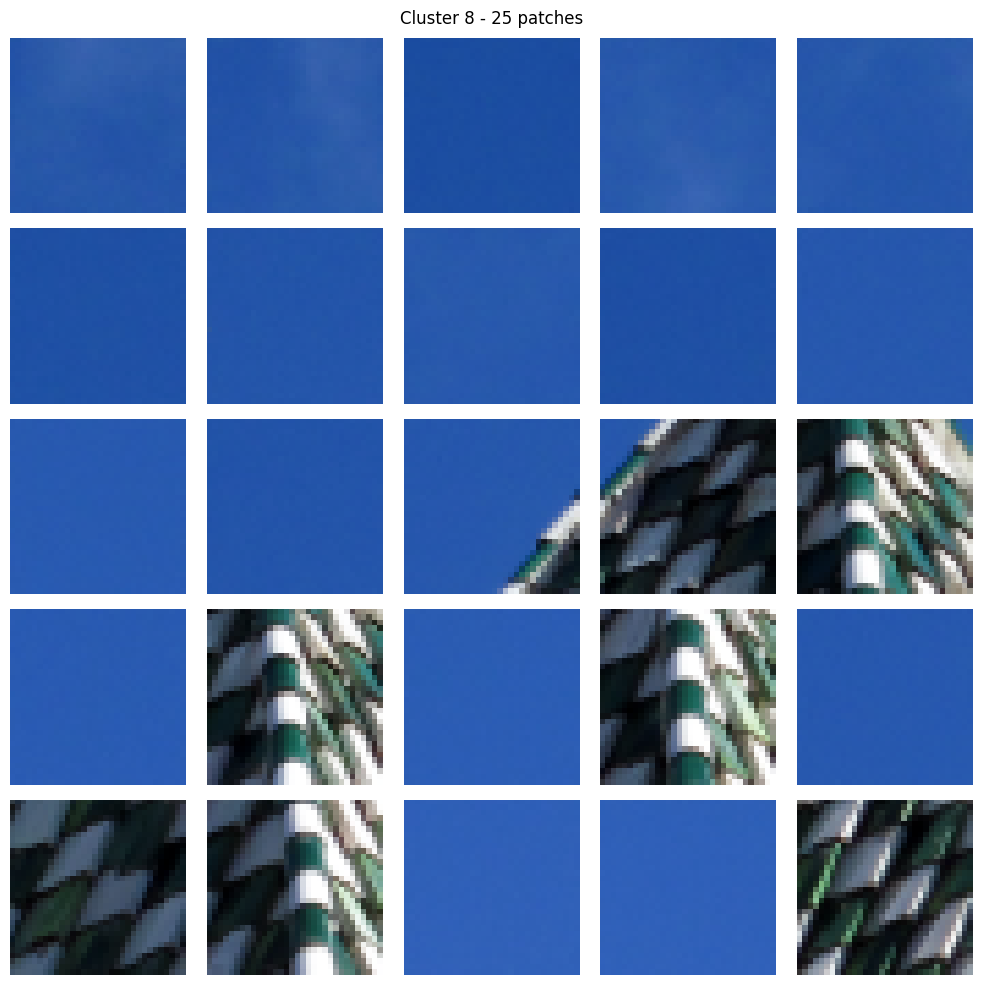

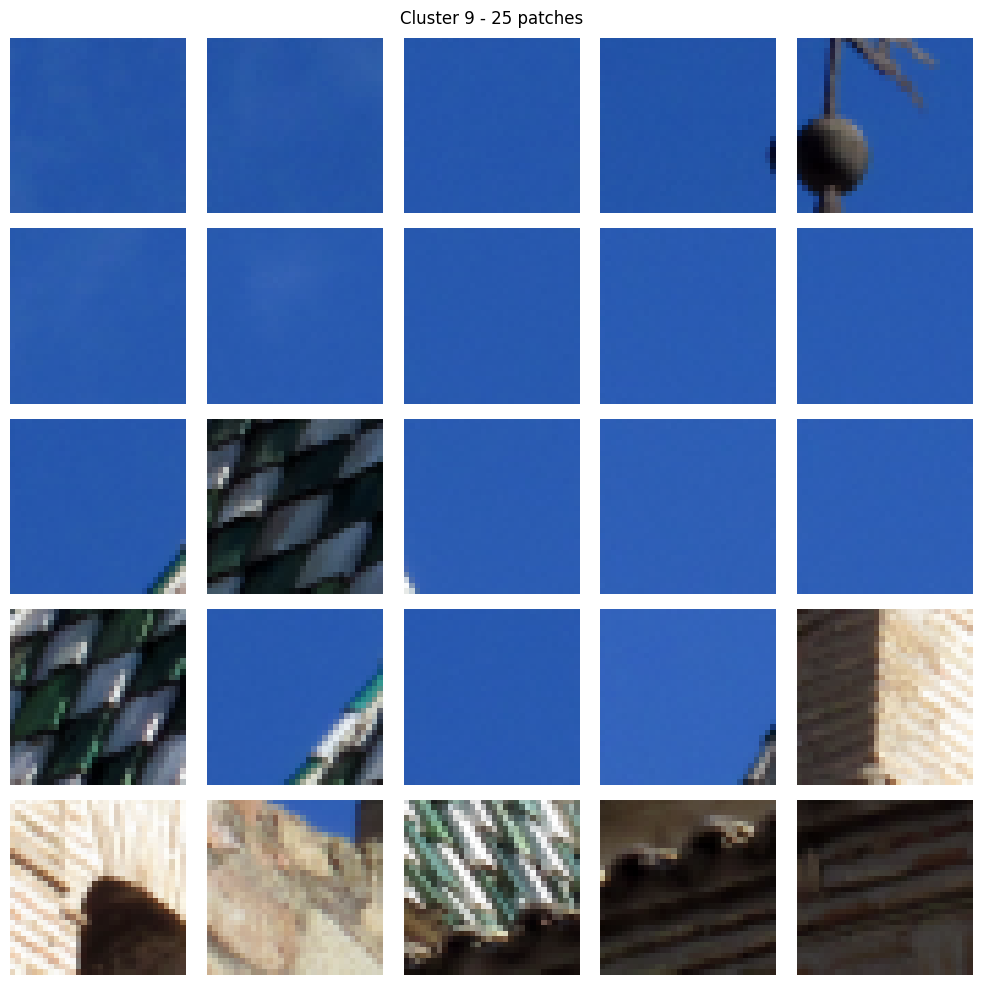

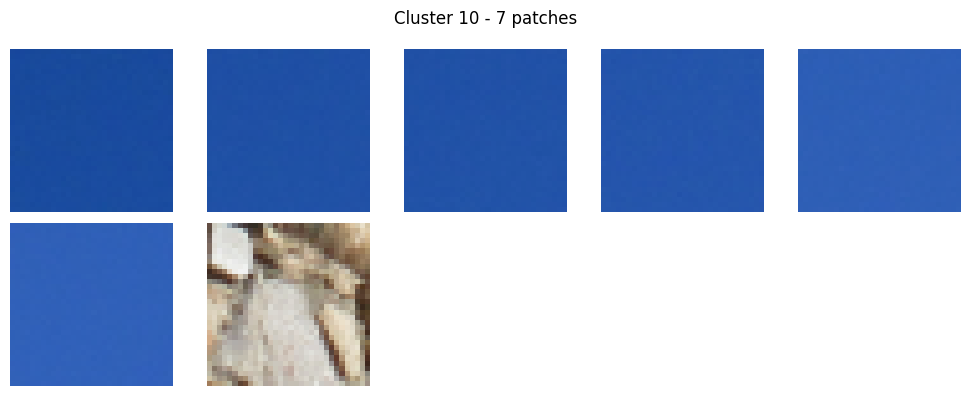

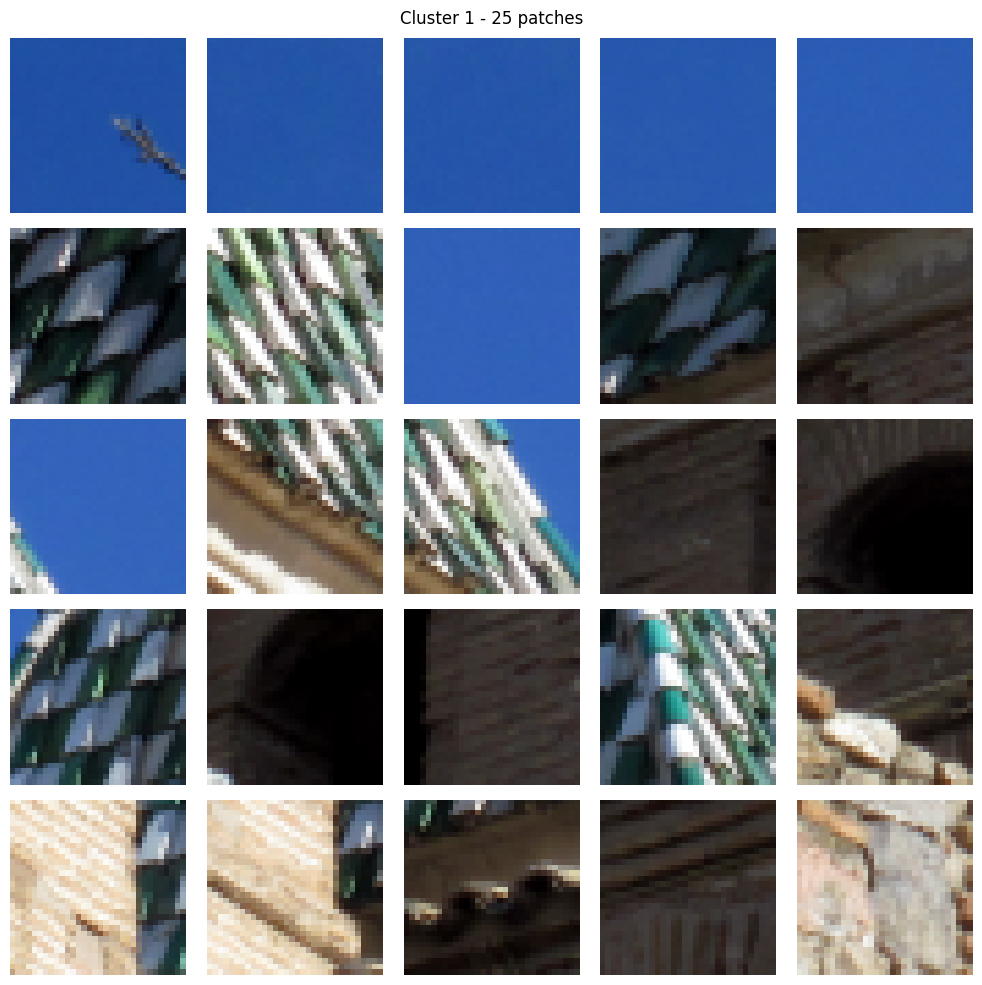

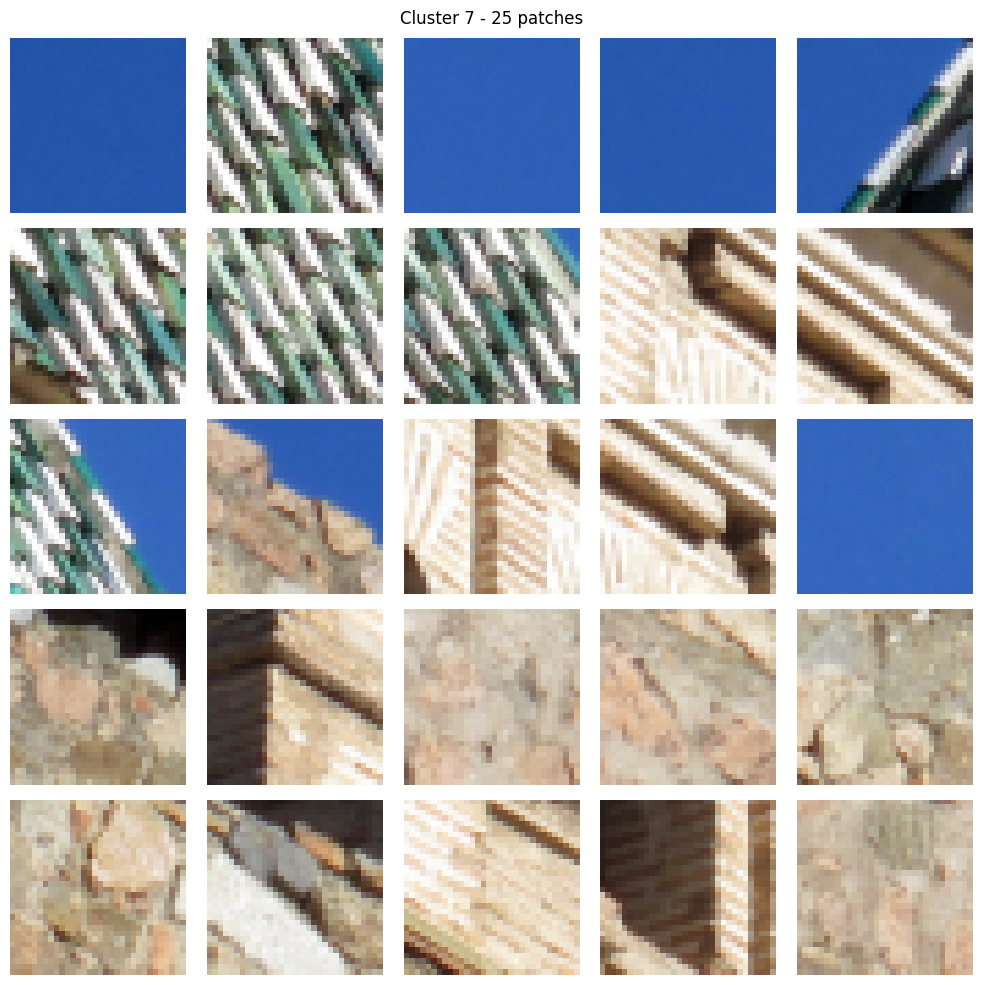

In [ ]:
from collections import defaultdict
import math

image_path = '/content/drive/MyDrive/latent_exp_2025/example_images/RGB_R02_0600x0600_007.png'
checkpoint_path = '/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt'

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
vae = PatchVAE(latent_channels=64, latent_hw=2).to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()

# Load and process image
image = Image.open(image_path).convert('RGB')
W, H = image.size
image = image.crop((0, 0, W - (W % 32), H - (H % 32)))
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

# Extract patches
def extract_patches_scanline(img_tensor, patch_size=32):
    B, C, H, W = img_tensor.shape
    patches, positions = [], []
    for row in range(0, H, patch_size):
        for col in range(0, W, patch_size):
            patch = img_tensor[:, :, row:row+patch_size, col:col+patch_size]
            patches.append(patch)
            positions.append((row // patch_size, col // patch_size))
    return patches, positions

patches, _ = extract_patches_scanline(image_tensor)

# Extract latents
scan_latents = []
with torch.no_grad():
    for patch in patches:
        _, _, _, z = vae(patch, quantize=True)
        z_flat = z.view(-1)
        scan_latents.append(z_flat.cpu())

# Stack and normalize
scan_latents_tensor = torch.stack(scan_latents)
scan_latents_np = scan_latents_tensor.numpy()
latents_std = StandardScaler().fit_transform(scan_latents_np)

# UMAP graph + Louvain
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean')
reducer.fit(latents_std)
umap_graph = reducer.graph_
G = nx.from_scipy_sparse_array(umap_graph)
partition = community_louvain.best_partition(G)
cluster_labels = [partition[i] for i in range(len(patches))]

# Visualize
def visualize_patches_by_cluster(patches, cluster_labels, max_patches_per_cluster=25):
    cluster_dict = defaultdict(list)
    for patch, label in zip(patches, cluster_labels):
        cluster_dict[label].append(patch.cpu())
    for cluster_id, patch_list in cluster_dict.items():
        patch_list = patch_list[:max_patches_per_cluster]
        n = len(patch_list)
        rows = int(math.ceil(n / 5))
        cols = min(n, 5)
        plt.figure(figsize=(cols * 2, rows * 2))
        for i, p in enumerate(patch_list):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(p.squeeze(0).permute(1, 2, 0).numpy())
            plt.axis('off')
        plt.suptitle(f"Cluster {cluster_id} - {n} patches")
        plt.tight_layout()
        plt.show()

import pandas as pd

# Create and print dataframe showing patch-cluster mapping
df = pd.DataFrame({'Patch Index': list(range(len(patches))), 'Cluster': cluster_labels})
print(df.value_counts('Cluster').sort_index())  # shows how many patches per cluster

# Optional: Save it if needed
df.to_csv("patch_cluster_assignments.csv", index=False)

# Visualize the patches grouped by cluster
visualize_patches_by_cluster(patches, cluster_labels)


In [ ]:
scan_latents[0]

tensor([-0.,  1., -1.,  ..., -2., -1., -2.])

In [ ]:
vae.eval()
recon_patches = []

with torch.no_grad():
    for patch in patches:
        recon, _, _, z = vae(patch, quantize=True)  # ✅ enable quantization
        print(z)
        recon_patches.append(recon.squeeze(0).cpu())

Streaming output truncated to the last 5000 lines.
         [[ 1., -0.,  0.,  0.],
          [-1., -0.,  0., -1.],
          [ 1., -0., -1.,  1.],
          [ 0., -2., -0.,  1.]],

         [[-1., -0., -1.,  0.],
          [ 1.,  0.,  1., -0.],
          [-0., -2., -0.,  1.],
          [ 1., -1., -1., -1.]]]])
tensor([[[[-1.,  1., -1., -2.],
          [ 3., -1., -0.,  0.],
          [-0.,  0., -1.,  0.],
          [ 0., -0., -1.,  0.]],

         [[-1.,  0., -1., -1.],
          [-0.,  0., -0.,  1.],
          [-0.,  1., -1.,  1.],
          [-0., -1., -0.,  1.]],

         [[ 0.,  1.,  0.,  0.],
          [-1., -1., -1.,  1.],
          [-1.,  0., -0.,  1.],
          [ 2.,  1., -1., -0.]],

         ...,

         [[-1., -1., -2., -1.],
          [-1.,  0., -0., -0.],
          [ 2., -0., -1., -0.],
          [-1.,  0., -1., -1.]],

         [[-0.,  0., -1.,  0.],
          [ 1.,  0., -1.,  3.],
          [ 1., -0., -2.,  1.],
          [-0.,  1.,  1., -1.]],

         [[ 1.,  1., -0

In [ ]:
# Determine number of rows and cols from positions
num_rows = max([pos[0] for pos in positions]) + 1
num_cols = max([pos[1] for pos in positions]) + 1

# Create empty canvas
canvas = torch.zeros(3, num_rows * 32, num_cols * 32)

# Paste patches in correct positions
for patch, (i, j) in zip(recon_patches, positions):
    canvas[:, i*32:(i+1)*32, j*32:(j+1)*32] = patch

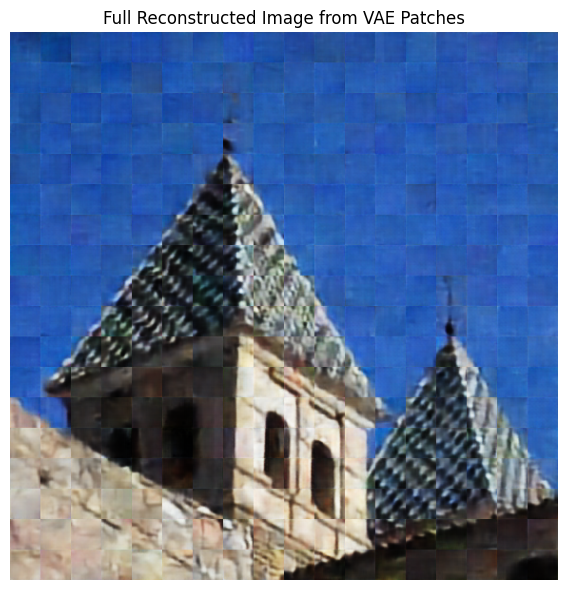

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(canvas.permute(1, 2, 0).numpy())
plt.title("Full Reconstructed Image from VAE Patches")
plt.axis('off')
plt.tight_layout()
plt.show()